In [1]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lightgbm import LGBMClassifier, plot_importance
import shap
import warnings
warnings.filterwarnings(action='ignore')

c:\Users\wlsdn\anaconda3\envs\cal2023\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Fixed Seed

In [4]:
train = pd.read_csv('re_train_preprocessed.csv')
test = pd.read_csv('re_test_preprocessed.csv')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0)

In [7]:
train[['Estimated_Departure_Time','Origin_Airport']]

Estimated_Departure_Time Origin_Airport
0                            NaN            OKC
1                           40.0            ORD
2                          670.0            CLT
3                          245.0            LAX
4                           60.0            SFO
...                          ...            ...
999995                     276.0            ORD
999996                     200.0            FAR
999997                     120.0            OAK
999998                     673.0            BNA
999999                     780.0            RSW

[1000000 rows x 2 columns]

In [21]:
train.describe()

Month    Day_of_Month  Estimated_Departure_Time  \
count  1000000.000000  1000000.000000             890981.000000   
mean         6.945156       15.764842                615.812905   
std          3.462506        8.763515                439.885738   
min          1.000000        1.000000                  0.000000   
25%          4.000000        8.000000                285.000000   
50%          7.000000       16.000000                560.000000   
75%         10.000000       23.000000                820.000000   
max         12.000000       31.000000               2359.000000   

       Estimated_Arrival_Time        Distance  Carrier_ID(DOT)  
count           890960.000000  1000000.000000    988117.000000  
mean               700.916590      784.078499     19997.529488  
std                438.833267      590.790469       404.266115  
min                  0.000000       16.000000     19393.000000  
25%                375.000000      350.000000     19790.000000  
50%                654.000000      623.000000     19977.000000  
75%                921.000000     1020.000000     20378.000000  
max               2400.000000     5095.000000     21171.000000

In [22]:
for i in train:
    print(i, sum(train[i].isnull()))

ID 0
Month 0
Day_of_Month 0
Estimated_Departure_Time 109019
Estimated_Arrival_Time 109040
Origin_Airport 0
Origin_State 0
Destination_Airport 0
Destination_State 0
Distance 0
Airline 11883
Carrier_Code(IATA) 1273
Carrier_ID(DOT) 11883
Tail_Number 0
Delay 744999


In [23]:
train.head()

ID  Month  Day_of_Month  Estimated_Departure_Time  \
0  TRAIN_000000      4            15                       NaN   
1  TRAIN_000001      8            15                      40.0   
2  TRAIN_000002      9             6                     670.0   
3  TRAIN_000003      7            10                     245.0   
4  TRAIN_000004      1            11                      60.0   

   Estimated_Arrival_Time Origin_Airport    Origin_State Destination_Airport  \
0                     NaN            OKC        Oklahoma                 HOU   
1                   264.0            ORD        Illinois                 SLC   
2                   785.0            CLT  North Carolina                 LGA   
3                   575.0            LAX      California                 EWR   
4                   139.0            SFO      California                 ACV   

  Destination_State  Distance                 Airline Carrier_Code(IATA)  \
0             Texas       419  Southwest Airlines Co.                 WN   
1              Utah      1250   SkyWest Airlines Inc.                 UA   
2          New York       544  American Airlines Inc.                 AA   
3        New Jersey      2454   United Air Lines Inc.                 UA   
4        California       250   SkyWest Airlines Inc.                 UA   

   Carrier_ID(DOT) Tail_Number Delay  
0          19393.0      N7858A   NaN  
1          20304.0      N125SY   NaN  
2          19805.0      N103US   NaN  
3          19977.0      N595UA   NaN  
4          20304.0      N161SY   NaN

In [24]:
train['Delay'].describe()

count          255001
unique              2
top       Not_Delayed
freq           210001
Name: Delay, dtype: object

In [30]:
plt_train = train.drop(columns=['Delay', 'ID','Airline', 'Carrier_Code(IATA)', 'Origin_State', 'Destination_State'])
plt_test = test.drop(columns=['ID','Airline', 'Carrier_Code(IATA)', 'Origin_State', 'Destination_State'])
plt_train = plt_train.dropna()

In [31]:
plt_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 784152 entries, 1 to 999999
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Month                     784152 non-null  int64  
 1   Day_of_Month              784152 non-null  int64  
 2   Estimated_Departure_Time  784152 non-null  float64
 3   Estimated_Arrival_Time    784152 non-null  float64
 4   Origin_Airport            784152 non-null  object 
 5   Destination_Airport       784152 non-null  object 
 6   Distance                  784152 non-null  int64  
 7   Carrier_ID(DOT)           784152 non-null  float64
 8   Tail_Number               784152 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 59.8+ MB


In [32]:
#질적 변수들을 수치화합니다
qual_col = ['Origin_Airport', 'Destination_Airport', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(plt_train[i])
    plt_train[i]=le.transform(plt_train[i])
    
    for label in np.unique(plt_test[i]):
        print(label, i)
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    plt_test[i]=le.transform(plt_test[i])
print('Done.')

ABE Origin_Airport
ABI Origin_Airport
ABQ Origin_Airport
ABR Origin_Airport
ABY Origin_Airport
ACK Origin_Airport
ACT Origin_Airport
ACV Origin_Airport
ACY Origin_Airport
ADK Origin_Airport
ADQ Origin_Airport
AEX Origin_Airport
AGS Origin_Airport
AKN Origin_Airport
ALB Origin_Airport
ALO Origin_Airport
ALW Origin_Airport
AMA Origin_Airport
ANC Origin_Airport
APN Origin_Airport
ART Origin_Airport
ASE Origin_Airport
ATL Origin_Airport
ATW Origin_Airport
ATY Origin_Airport
AUS Origin_Airport
AVL Origin_Airport
AVP Origin_Airport
AZA Origin_Airport
AZO Origin_Airport
BDL Origin_Airport
BET Origin_Airport
BFF Origin_Airport
BFL Origin_Airport
BFM Origin_Airport
BGM Origin_Airport
BGR Origin_Airport
BHM Origin_Airport
BIL Origin_Airport
BIS Origin_Airport
BJI Origin_Airport
BKG Origin_Airport
BLI Origin_Airport
BLV Origin_Airport
BMI Origin_Airport
BNA Origin_Airport
BOI Origin_Airport
BOS Origin_Airport
BPT Origin_Airport
BQK Origin_Airport
BQN Origin_Airport
BRD Origin_Airport
BRO Origin_A

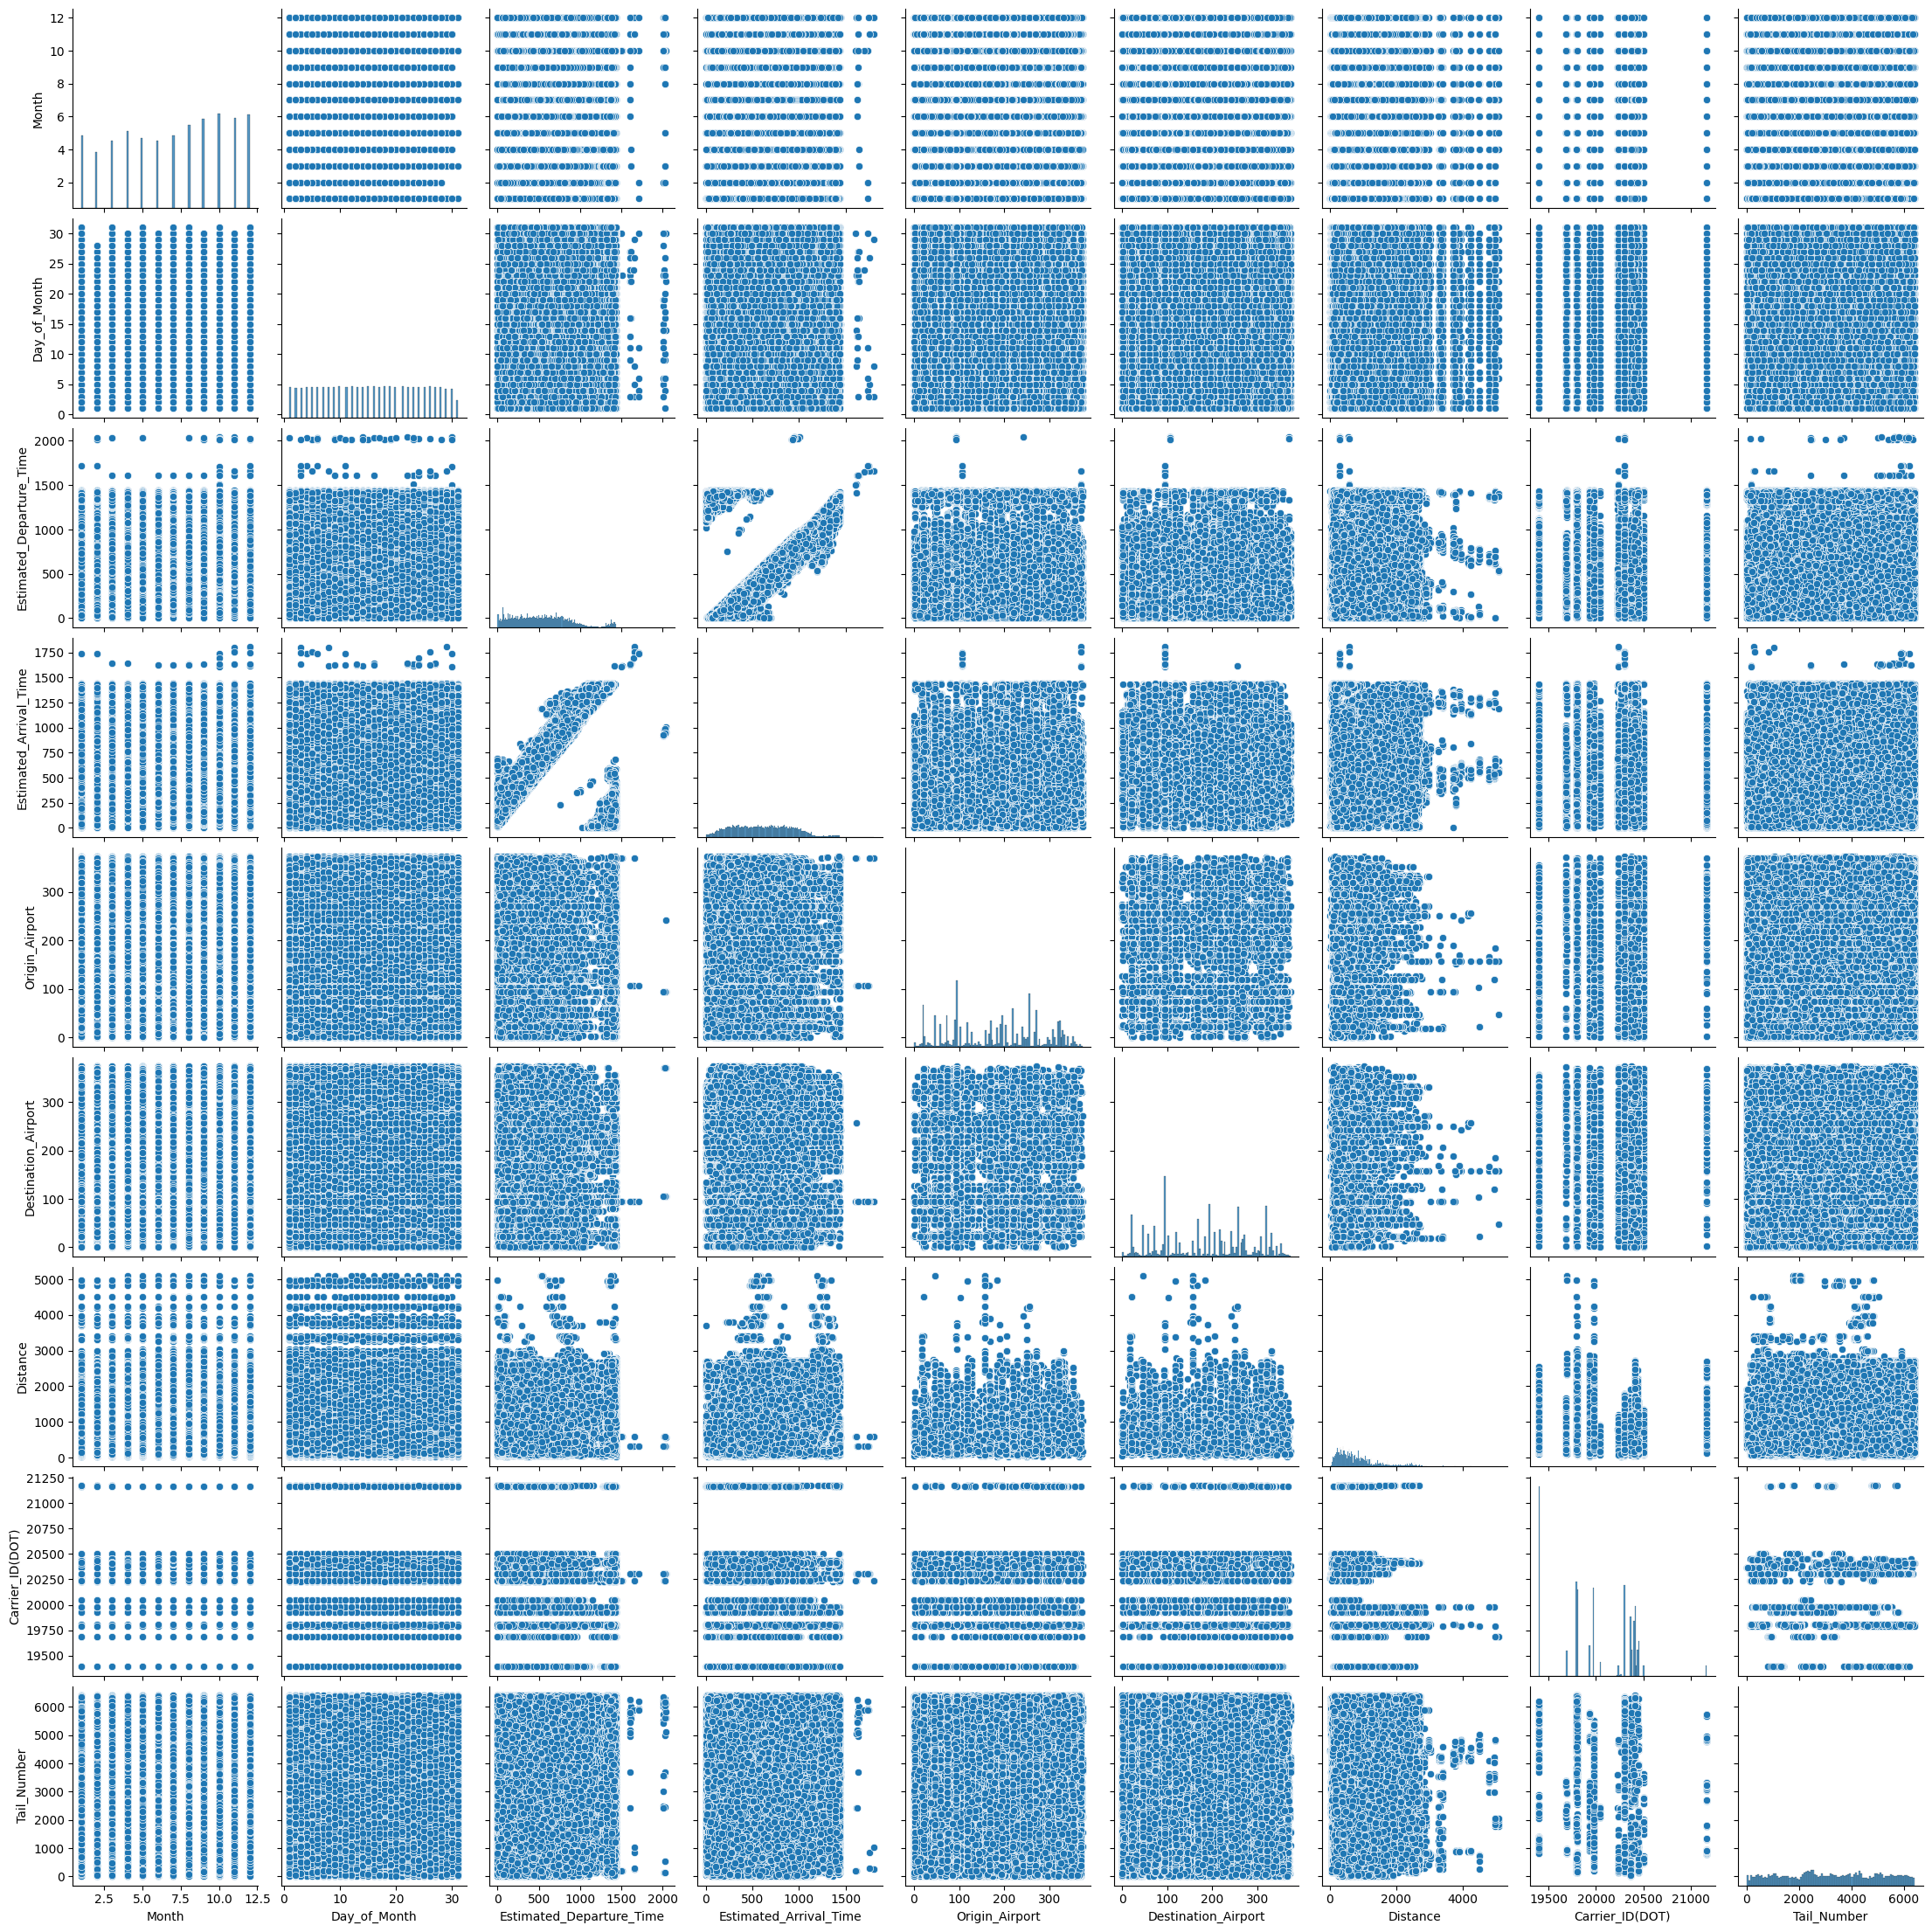

In [33]:
sns.pairplot(plt_train);

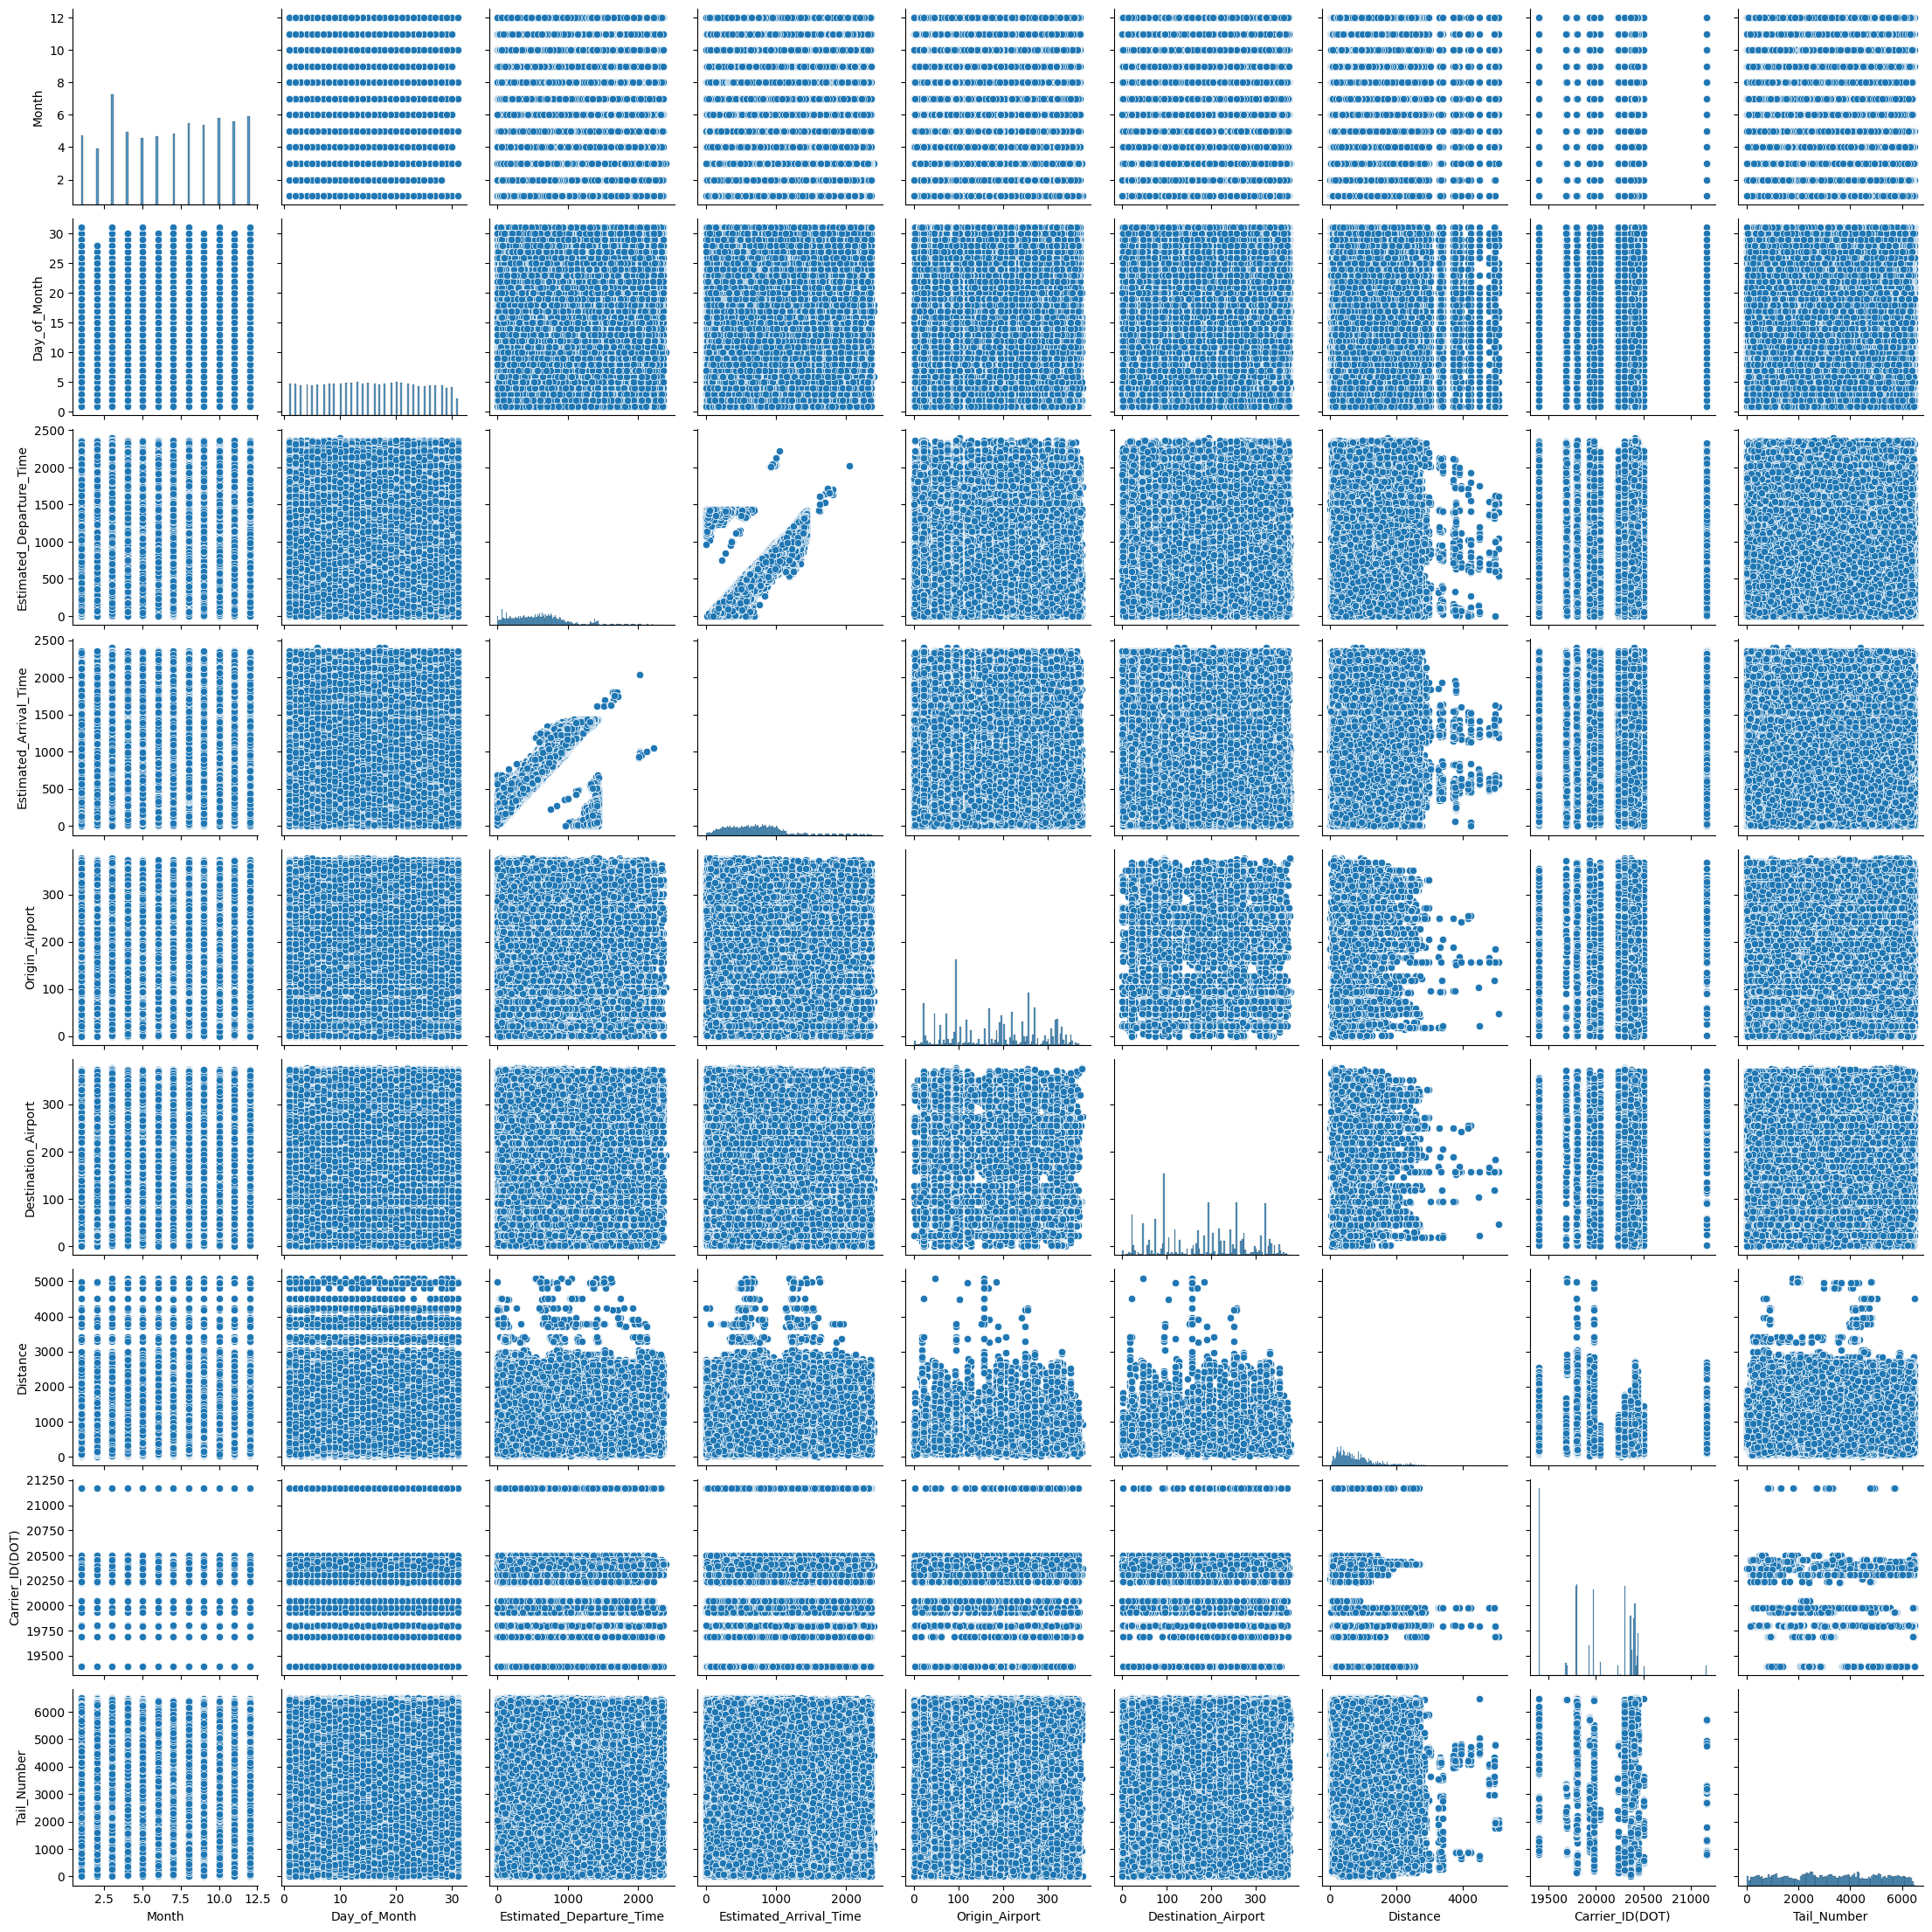

In [36]:
sns.pairplot(plt_test)

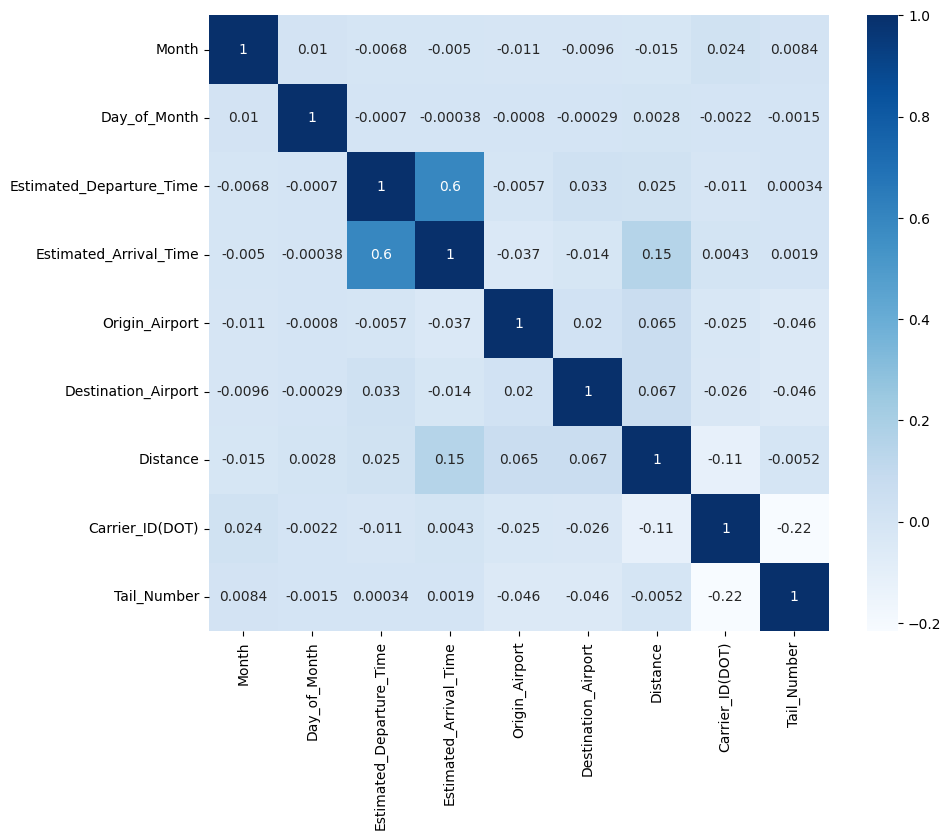

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(plt_train.corr(), annot=True, cmap='Blues')
plt.show()

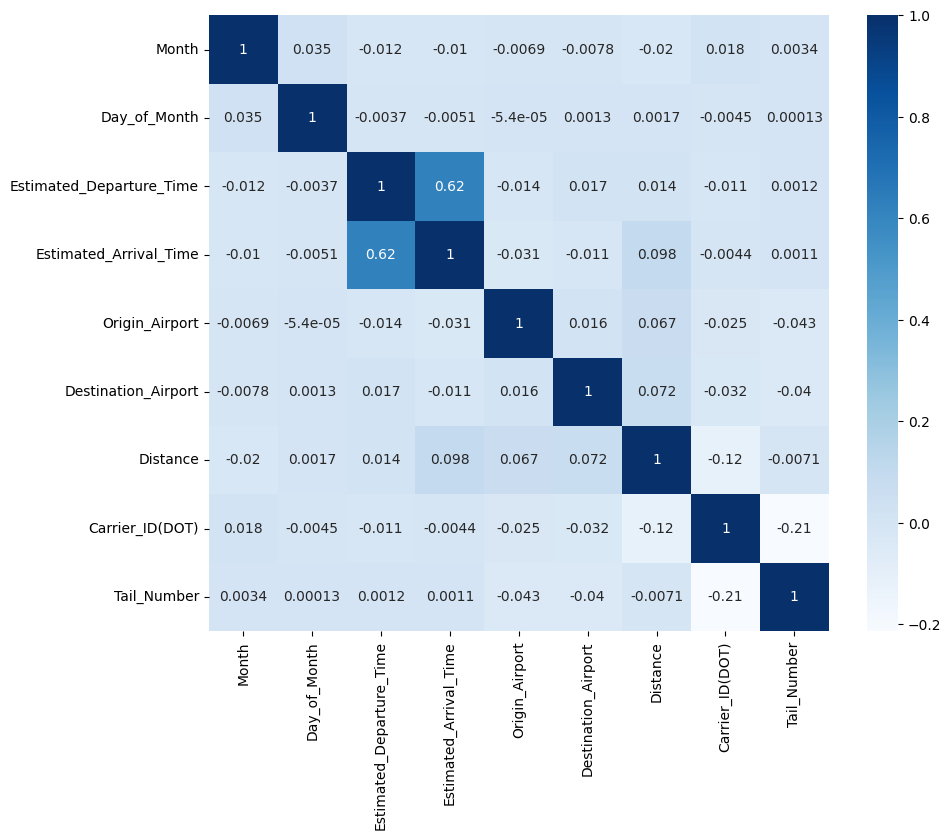

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(plt_test.corr(), annot=True, cmap='Blues')
plt.show()

In [94]:
mice_train = train.drop(columns=['ID', 'Origin_State', 'Destination_State', 'Airline', 'Carrier_Code(IATA)', 'Carrier_ID(DOT)', 'Origin_Airport', 'Destination_Airport', 'Tail_Number', 'Delay'])
mice_test = test.drop(columns=['ID', 'Origin_State', 'Destination_State', 'Airline', 'Carrier_Code(IATA)', 'Carrier_ID(DOT)', 'Origin_Airport', 'Destination_Airport', 'Tail_Number'])

In [95]:
imputer_mice = IterativeImputer(random_state=42)
mice_train = imputer_mice.fit_transform(mice_train)
mice_test = imputer_mice.transform(mice_test)

In [96]:
feature_name_in_mice = train.drop(columns=['ID', 'Origin_State', 'Destination_State', 'Airline', 'Carrier_Code(IATA)', 'Carrier_ID(DOT)', 'Origin_Airport', 'Destination_Airport', 'Tail_Number', 'Delay']).columns

In [97]:
mice_train = pd.DataFrame(mice_train, columns=feature_name_in_mice)

In [98]:
mice_test = pd.DataFrame(mice_test, columns=feature_name_in_mice)

In [99]:
from copy import deepcopy
new_train = deepcopy(train)

In [100]:
new_test = deepcopy(test)

In [101]:
for i in feature_name_in_mice:
    new_train[i] = mice_train[i]
    new_test[i] = mice_test[i]

In [102]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 15 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  float64
 2   Day_of_Month              1000000 non-null  float64
 3   Estimated_Departure_Time  1000000 non-null  float64
 4   Estimated_Arrival_Time    1000000 non-null  float64
 5   Origin_Airport            1000000 non-null  int32  
 6   Origin_State              1000000 non-null  object 
 7   Destination_Airport       1000000 non-null  int32  
 8   Destination_State         1000000 non-null  object 
 9   Distance                  1000000 non-null  float64
 10  Airline                   988117 non-null   object 
 11  Carrier_Code(IATA)        998727 non-null   object 
 12  Carrier_ID(DOT)           988117 non-null   float64
 13  Tail_Number               10

In [58]:
first_test_set = new_train[new_train['Delay'].isnull()]
first_train_set = new_train.dropna()

In [59]:
first_train_set.dropna()

ID  Month  Day_of_Month  Estimated_Departure_Time  \
5       TRAIN_000005    4.0          13.0               1545.000000   
6       TRAIN_000006    1.0          20.0                762.000000   
8       TRAIN_000008    6.0          13.0                560.000000   
10      TRAIN_000010    8.0          13.0                750.000000   
12      TRAIN_000012    1.0          12.0                195.000000   
...              ...    ...           ...                       ...   
999962  TRAIN_999962   10.0          11.0               1787.790213   
999963  TRAIN_999963    5.0           2.0                779.000000   
999969  TRAIN_999969   10.0          10.0                220.000000   
999985  TRAIN_999985    8.0           8.0                854.000000   
999992  TRAIN_999992   12.0          30.0                427.000000   

        Estimated_Arrival_Time Origin_Airport    Origin_State  \
5                  1400.971184            EWR      New Jersey   
6                   843.000000            EWR      New Jersey   
8                   650.000000            BWI        Maryland   
10                  824.000000            DCA        Virginia   
12                  405.000000            CLE            Ohio   
...                        ...            ...             ...   
999962             2003.000000            SAT           Texas   
999963              866.000000            LGA        New York   
999969              296.000000            MFE           Texas   
999985              939.000000            RDU  North Carolina   
999992              607.000000            JAC         Wyoming   

       Destination_Airport Destination_State  Distance  \
5                      DCA          Virginia     199.0   
6                      BOS     Massachusetts     200.0   
8                      CLT    North Carolina     361.0   
10                     PIT      Pennsylvania     204.0   
12                     DEN          Colorado    1201.0   
...                    ...               ...       ...   
999962                 ORD          Illinois    1041.0   
999963                 DCA          Virginia     214.0   
999969                 IAH             Texas     316.0   
999985                 JAX           Florida     407.0   
999992                 ORD          Illinois    1162.0   

                       Airline Carrier_Code(IATA)  Carrier_ID(DOT)  \
5            Republic Airlines                 UA          20452.0   
6        United Air Lines Inc.                 UA          19977.0   
8       Southwest Airlines Co.                 WN          19393.0   
10           Republic Airlines                 AA          20452.0   
12      Southwest Airlines Co.                 WN          19393.0   
...                        ...                ...              ...   
999962   SkyWest Airlines Inc.                 UA          20304.0   
999963       Republic Airlines                 DL          20452.0   
999969      Mesa Airlines Inc.                 UA          20378.0   
999985  Frontier Airlines Inc.                 F9          20436.0   
999992   United Air Lines Inc.                 UA          19977.0   

       Tail_Number        Delay  
5           N657RW  Not_Delayed  
6           N66825  Not_Delayed  
8           N765SW  Not_Delayed  
10          N119HQ      Delayed  
12          N8696E  Not_Delayed  
...            ...          ...  
999962      N152SY  Not_Delayed  
999963      N871RW      Delayed  
999969      N89321      Delayed  
999985      N316FR  Not_Delayed  
999992      N17719  Not_Delayed  

[252016 rows x 15 columns]

In [60]:
first_test_set['Delay'] = first_test_set['Delay'].fillna(0)
first_test_set = first_test_set.dropna()

In [61]:
first_test_X = first_test_set.drop(columns=['Delay', 'ID','Airline', 'Carrier_Code(IATA)', 'Origin_State', 'Destination_State'])
first_test_y = first_test_set[['Delay']]
first_train_X = first_train_set.drop(columns=['Delay', 'ID','Airline', 'Carrier_Code(IATA)', 'Origin_State', 'Destination_State'])
first_train_y = first_train_set[['Delay']]

In [62]:
first_train_X.head()

Month  Day_of_Month  Estimated_Departure_Time  Estimated_Arrival_Time  \
5     4.0          13.0                    1545.0             1400.971184   
6     1.0          20.0                     762.0              843.000000   
8     6.0          13.0                     560.0              650.000000   
10    8.0          13.0                     750.0              824.000000   
12    1.0          12.0                     195.0              405.000000   

   Origin_Airport Destination_Airport  Distance  Carrier_ID(DOT) Tail_Number  
5             EWR                 DCA     199.0          20452.0      N657RW  
6             EWR                 BOS     200.0          19977.0      N66825  
8             BWI                 CLT     361.0          19393.0      N765SW  
10            DCA                 PIT     204.0          20452.0      N119HQ  
12            CLE                 DEN    1201.0          19393.0      N8696E

In [63]:
feature_name = first_test_X.columns

In [64]:
#질적 변수들을 수치화합니다
qual_col = ['Origin_Airport', 'Destination_Airport', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(first_train_X[i])
    first_train_X[i]=le.transform(first_train_X[i])
    
    for label in np.unique(first_test_X[i]):
        print(label, i)
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    first_test_X[i]=le.transform(first_test_X[i])
print('Done.')

ABE Origin_Airport
ABI Origin_Airport
ABQ Origin_Airport
ABR Origin_Airport
ABY Origin_Airport
ACK Origin_Airport
ACT Origin_Airport
ACV Origin_Airport
ACY Origin_Airport
ADK Origin_Airport
ADQ Origin_Airport
AEX Origin_Airport
AGS Origin_Airport
AKN Origin_Airport
ALB Origin_Airport
ALO Origin_Airport
ALW Origin_Airport
AMA Origin_Airport
ANC Origin_Airport
APN Origin_Airport
ART Origin_Airport
ASE Origin_Airport
ATL Origin_Airport
ATW Origin_Airport
ATY Origin_Airport
AUS Origin_Airport
AVL Origin_Airport
AVP Origin_Airport
AZA Origin_Airport
AZO Origin_Airport
BDL Origin_Airport
BET Origin_Airport
BFF Origin_Airport
BFL Origin_Airport
BFM Origin_Airport
BGM Origin_Airport
BGR Origin_Airport
BHM Origin_Airport
BIL Origin_Airport
BIS Origin_Airport
BJI Origin_Airport
BKG Origin_Airport
BLI Origin_Airport
BLV Origin_Airport
BMI Origin_Airport
BNA Origin_Airport
BOI Origin_Airport
BOS Origin_Airport
BPT Origin_Airport
BQK Origin_Airport
BQN Origin_Airport
BRD Origin_Airport
BRO Origin_A

In [65]:
# 교육 데이터는 교육 및 검증 세트로 분할되고 수치 기능은 StandardScaler를 사용하여 정규화됩니다.
# 모델은 GridSearchCV와 5겹 교차 검증을 사용하여 수행되는 하이퍼파라미터 튜닝과 함께 XGBClassifier를 사용하여 훈련됩니다.
# Split the training dataset into a training set and a validation set
first_train_X, first_val_X, first_train_y, first_val_y = train_test_split(first_train_X, first_train_y, test_size=0.3, random_state=42)

# Normalize numerical features
scaler = StandardScaler()
first_train_X = scaler.fit_transform(first_train_X)
first_val_X = scaler.transform(first_val_X)
first_test_X = scaler.transform(first_test_X)


In [66]:
# Cross-validation with StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [67]:
first_train_y.loc[first_train_y['Delay']=='Delayed', 'Delay'] = False
first_train_y.loc[first_train_y['Delay']=='Not_Delayed', 'Delay'] = True
first_val_y.loc[first_val_y['Delay']=='Delayed', 'Delay'] = False
first_val_y.loc[first_val_y['Delay']=='Not_Delayed', 'Delay'] = True
first_train_y

Delay
670162   True
926259   True
454099  False
679173   True
307164   True
...       ...
475067   True
411105   True
523151   True
582972   True
483296   True

[176411 rows x 1 columns]

In [68]:
train_x = pd.DataFrame(first_train_X, columns=feature_name)
train_y = pd.DataFrame(first_train_y, columns=['Delay'])
val_x = pd.DataFrame(first_val_X, columns=feature_name)
val_y = pd.DataFrame(first_val_y, columns=['Delay'])
test_x = pd.DataFrame(first_test_X, columns=feature_name)

In [69]:
train_x = train_x.astype('int')
train_y = train_y.astype('int')
val_x = val_x.astype('int')
val_y = val_y.astype('int')

In [70]:
# Model and hyperparameter tuning using GridSearchCV
# model = LGBMClassifier(n_estimators=1000, objective='binary', metric = 'binary_logloss', reg_lambda=True, max_depth=7, is_unbalance = True, learning_rate=0.01, n_jobs=-1, random_state=42)
model = LGBMClassifier(n_estimators=1000, max_depth=7, learning_rate=0.005, n_jobs=-1, objective='binary', metric='binary_logloss', )

In [71]:
model.fit(train_x, train_y, eval_metric='logloss', eval_set = [(val_x, val_y)])

[1]	valid_0's binary_logloss: 0.46445
[2]	valid_0's binary_logloss: 0.464386
[3]	valid_0's binary_logloss: 0.464322
[4]	valid_0's binary_logloss: 0.464258
[5]	valid_0's binary_logloss: 0.464195
[6]	valid_0's binary_logloss: 0.464133
[7]	valid_0's binary_logloss: 0.464072
[8]	valid_0's binary_logloss: 0.464011
[9]	valid_0's binary_logloss: 0.463951
[10]	valid_0's binary_logloss: 0.463892
[11]	valid_0's binary_logloss: 0.463833
[12]	valid_0's binary_logloss: 0.463774
[13]	valid_0's binary_logloss: 0.463716
[14]	valid_0's binary_logloss: 0.463659
[15]	valid_0's binary_logloss: 0.463602
[16]	valid_0's binary_logloss: 0.463546
[17]	valid_0's binary_logloss: 0.46349
[18]	valid_0's binary_logloss: 0.463435
[19]	valid_0's binary_logloss: 0.463381
[20]	valid_0's binary_logloss: 0.463327
[21]	valid_0's binary_logloss: 0.463274
[22]	valid_0's binary_logloss: 0.463221
[23]	valid_0's binary_logloss: 0.463169
[24]	valid_0's binary_logloss: 0.463118
[25]	valid_0's binary_logloss: 0.463066
[26]	valid_

LGBMClassifier(learning_rate=0.005, max_depth=7, metric='binary_logloss',
               n_estimators=1000, objective='binary')

[Text(0.5, 1.0, 'Feature Importance (gain)'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0, 0.5, 'Features')]

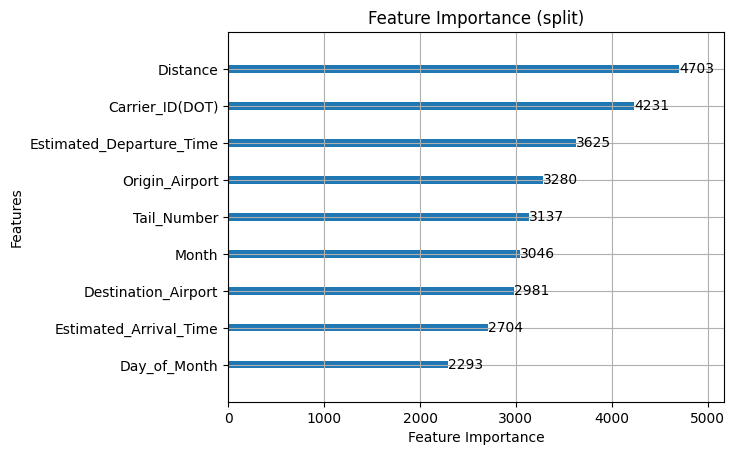

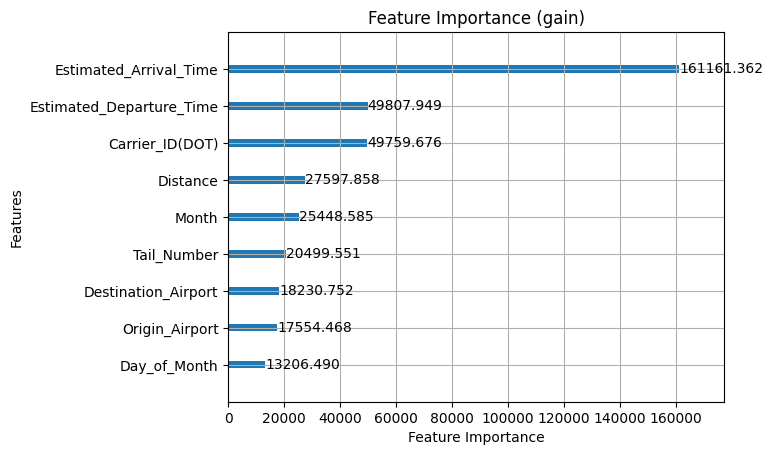

In [72]:
# Split
ax = plot_importance(model, max_num_features=len(feature_name), importance_type='split')
ax.set(title=f'Feature Importance (split)',
	xlabel='Feature Importance',
	ylabel='Features')

# GAIN
ax = plot_importance(model, max_num_features=len(feature_name), importance_type='gain')
ax.set(title=f'Feature Importance (gain)',
	xlabel='Feature Importance',
	ylabel='Features')

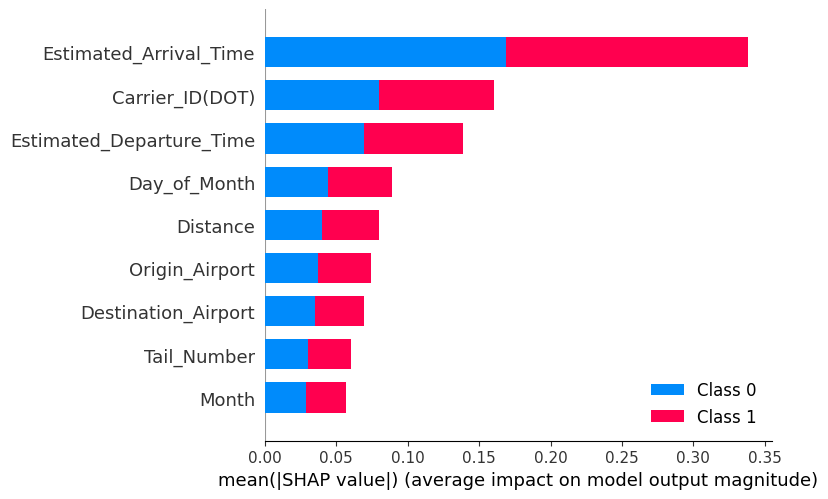

In [73]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(val_x)
shap.summary_plot(shap_values, val_x)
# plt.savefig('./shap.png', dpi=300, bbox_inches="tight")

In [74]:
features = []
for i in feature_name:
    features.append(i)

In [75]:
from eli5.lightgbm import *
from eli5.sklearn import *
import eli5

perm = PermutationImportance(model, random_state=42).fit(val_x, val_y)
print(eli5.format_as_text(explain_weights.explain_permutation_importance(perm, feature_names = features, top=40)))

explain_weights.explain_permutation_importance(perm, feature_names = features, top=47)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

     0 ± 0.0000  Tail_Number
     0 ± 0.0000  Carrier_ID(DOT)
     0 ± 0.0000  Distance
     0 ± 0.0000  Destination_Airport
     0 ± 0.0000  Origin_Airport
     0 ± 0.0000  Estimated_Arrival_Time
     0 ± 0.0000  Estimated_Departure_Time
     0 ± 0.0000  Day_of_Month
     0 ± 0.0000  Month


Explanation(estimator="PermutationImportance(estimator=LGBMClassifier(learning_rate=0.005, max_depth=7,\n                                               metric='binary_logloss',\n                                               n_estimators=1000,\n                                               objective='binary'),\n                      random_state=42)", description="\nFeature importances, computed as a decrease in score when feature\nvalues are permuted (i.e. become noise). This is also known as \npermutation importance.\n\nIf feature importances are computed on the same data as used for training, \nthey don't reflect importance of features for generalization. Use a held-out\ndataset if you want generalization feature importances.\n", error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='Tail_Number', weight=0.0, std=0.0, value=None), FeatureWeight(feature='Carrier_ID(DOT)', weight=0.0, std=0.0, value=None), FeatureWeight(feature='Distance', weight=0.0, std=0.0, value=None), FeatureWeight(feature='Destination_Airport', weight=0.0, std=0.0, value=None), FeatureWeight(feature='Origin_Airport', weight=0.0, std=0.0, value=None), FeatureWeight(feature='Estimated_Arrival_Time', weight=0.0, std=0.0, value=None), FeatureWeight(feature='Estimated_Departure_Time', weight=0.0, std=0.0, value=None), FeatureWeight(feature='Day_of_Month', weight=0.0, std=0.0, value=None), FeatureWeight(feature='Month', weight=0.0, std=0.0, value=None)], remaining=0), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [103]:
for i in test:
    print(i, sum(new_test[i].isnull()))

ID 0
Month 0
Day_of_Month 0
Estimated_Departure_Time 0
Estimated_Arrival_Time 0
Origin_Airport 0
Origin_State 28
Destination_Airport 0
Destination_State 40
Distance 0
Airline 11543
Carrier_Code(IATA) 1259
Carrier_ID(DOT) 11543
Tail_Number 0


In [104]:
new_test = new_test.drop(columns=['ID','Origin_State','Destination_State','Airline','Carrier_Code(IATA)'])

In [110]:
new_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Month                     1000000 non-null  float64
 1   Day_of_Month              1000000 non-null  float64
 2   Estimated_Departure_Time  1000000 non-null  float64
 3   Estimated_Arrival_Time    1000000 non-null  float64
 4   Origin_Airport            1000000 non-null  int32  
 5   Destination_Airport       1000000 non-null  int32  
 6   Distance                  1000000 non-null  float64
 7   Carrier_ID(DOT)           988457 non-null   float64
 8   Tail_Number               1000000 non-null  int32  
dtypes: float64(6), int32(3)
memory usage: 57.2 MB


In [106]:
#레이블(Delay)을 제외한 결측값이 존재하는 변수들을 학습 데이터의 최빈값으로 대체합니다
NaN_col = ['Carrier_ID(DOT)']

for col in NaN_col:
    mode = train[col].mode()[0]
    train[col] = train[col].fillna(mode)
    
    if col in test.columns:
        test[col] = test[col].fillna(mode)
print('Done.')

Done.


In [107]:
#질적 변수들을 수치화합니다
qual_col = ['Origin_Airport', 'Destination_Airport', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])
print('Done.')

Done.


In [111]:
y_pred = model.predict_proba(new_test)

In [112]:
y_pred

array([[0.25923905, 0.74076095],
       [0.25923905, 0.74076095],
       [0.25923905, 0.74076095],
       ...,
       [0.25923905, 0.74076095],
       [0.25923905, 0.74076095],
       [0.25923905, 0.74076095]])

In [113]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('submission_5.csv', index=True)